# Forsøksplanlegging eksempel 1: Kjøretid til algoritme
### Prosjektmodul i ISTx1001

I dette eksempelet skal vi bruke forsøksplanlegging til å avgjøre hvordan to programmeringsvalg påvirker kjøretiden til en algoritme. I dette eksempelet er responsvariabelen $Y$ kjøretid (målt i sekunder). Algoritmen er en funksjon som kan brukes for illustrere sentralgrenseteoremet (en variant av denne ble presentert i Uke 6 av fellesmodulen). 

For et gitt antall simuleringer trekkes tallverdier fra $n$ uavhengige Poissonfordelte stokastiske variabler, alle med forventningsverdi $\mu = 3$. En slik trekning kan gjøres på to ulike måter (dette er faktor $A$ i forsøket vårt):
- Lavt nivå faktor $A$: $n$ observasjoner trekkes med `np.random.poisson(mu, size=n)`
- Høyt nivå faktor $A$: $n$ observasjoner trekkes en etter en med `np.random.poisson(mu)` i en for-løkke

Etter at $n$ tallverdier er trukket skal gjennomsnittet av disse regnes ut. Dette kan vi gjøre på to ulike måter (dette blir faktor $B$ i forsøket vårt):
- Lavt nivå faktor $B$: gjennomsnittet regnes ut med `np.mean(poisson_values)`
- Høyt nivå faktor $B$: gjennomsnittet regnes ut med `np.sum(poisson_values/n`


Designet kan presenteres slik:

<table> <tr><td>
    
| Forsøksnr. |
|:--------:|
| 1 |
| 2 |
| 3 |
| 4 |

</td><td>

| Faktor $A$ ($x_1$) | Faktor $B$ ($x_2$) |
|:--------:|:--------:|
| $-1$ | $-1$ |
| $+1$ | $-1$ | 
| $-1$ | $+1$ |
| $+1$ | $+1$ |

</td></tr> </table>

Med dette designet får vi altså 4 ulike faktorkombinasjoner, som tilsvarer 4 ulike algoritmer. Disse algoritene `simulate_poisson_average_1`, `simulate_poisson_average_2`, `simulate_poisson_average_3` og `simulate_poisson_average_4` finner du nederst i denne notatboken dersom du er interessert i å gjennomføre forsøket om igjen. 

I koden under har vi registrert observasjonene våre, visualisert og analysert dataene. Merk at dette ikke er et eksempel på strukturering av en prosjektrapport. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats

import time # for å registrere kjøretid til en algoritme

In [2]:
run DOEfunksjoner.ipynb 

In [3]:
# data-matrise
Xrep1 = tofaktorDOE(k=2)
Xrep2 = Xrep1 # x-verdiene holdes like i de to gjentakene

yrep1 = np.array([0.0243,0.1204,0.0195,0.1138]) # observerte kjøretider fra første repetisjon 
yrep2 = np.array([0.0251,0.1117,0.0196,0.1059]) # observerte kjøretider fra andre repetisjon

X = np.concatenate([Xrep1, Xrep2])
y = np.concatenate([yrep1,yrep2])

tab = np.column_stack([X, y])
colnames = ["x1", "x2", "y"]
dfgjentak = pd.DataFrame(tab, columns=colnames)

print(dfgjentak) # merk 0-indeksering i Python og merk at vi ikke manuelt regner ut gjennomsnittene over to gjentak

    x1   x2       y
0 -1.0 -1.0  0.0243
1  1.0 -1.0  0.1204
2 -1.0  1.0  0.0195
3  1.0  1.0  0.1138
4 -1.0 -1.0  0.0251
5  1.0 -1.0  0.1117
6 -1.0  1.0  0.0196
7  1.0  1.0  0.1059


### Hovedeffekter

Fra hovedeffektsplottene ser vi tydelig at kjøretiden øker når faktor A går fra høyt til lavt nivå. Det vil si at for-løkken for å trekke en og en observasjon fra en Poissonfordeling er vesentlig tregere enn den innebygde funksjonen fra scipy-pakken. For faktor B ser vi bare en ørliten nedgang når faktor B går fra lavt til høyt nivå. En nedgang vil tilsi at `np.mean(poisson_values)` er en tregere funksjon enn `np.sum(poisson_values)/n`, men i figuren er stignignstallet så nære null at vi ikke kan fastslå dette uten å se på statistisk signifikans. 

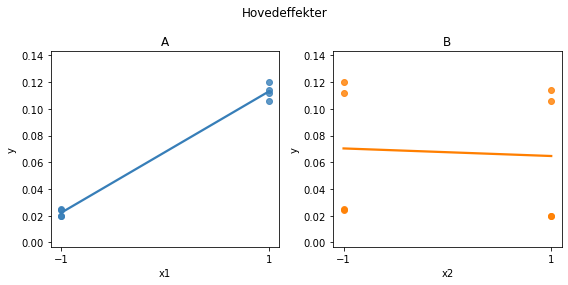

In [4]:
hovedeffektsplott(data = dfgjentak, k = 2)

## Samspillseffekter

I samspillsplottet ser vi to parallelle linjer. Dette tilsier at det ikke finnes noen samspillseffekt. Det ville forøvrig være rart om vi så et samspill siden de to ulike faktorene ikke har noe med hverandre å gjøre når algoritmen skrives.

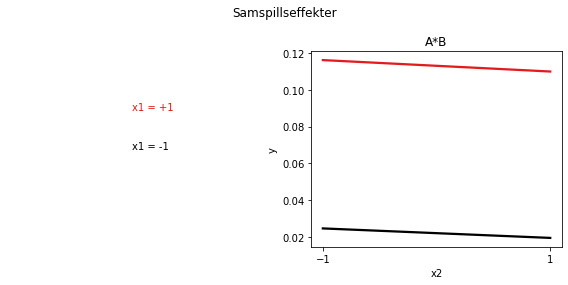

In [5]:
samspillsplott(data = dfgjentak,k = 2)

## Estimering av effekter
Vi estimerer hovedeffekter, samspillseffekt og ser på statistisk signifikans ved å tilpasse en multippel lineær regresjonsmodell til dataene (se resultater under). Regresjonsmodellen bekrefter det vi allerede har lest ut av figurene; faktor $A$ har den største estimerte hovedeffekten $\hat{A} = 2 \hat{\beta}_1 = 0.0908$ og det er kun denne effekten som er signifikant ulik null ved signifikansnivå $\alpha = 0.05$. Hovedeffekten til faktor $B$ er ikke signifikant ($p = 0.126$) og det er heller ikke samspillseffekten ($p = 0.867$). Forskjellen mellom effektene vises også tydelig i Paretoplottet. 

In [9]:
modell = smf.ols('y~x1+x2+x1*x2', data=dfgjentak).fit()
#print(modell.summary())

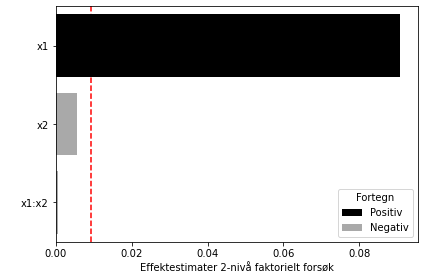

In [7]:
DOEparetoplott(modell)

### Her finner du algoritmer for de fire ulike faktorkombinasjonene

In [31]:
def simulate_poisson_average_1(nsim, n, mu): # x1 = -1, x2 = -1
    averages = []  

    for i in range(nsim):
        # Trekk observasjoner fra n uavhengige Poissonfordelte variabler
        poisson_values = np.random.poisson(mu, size=n)

        # Regn ut gjennomsnittet
        average = np.mean(poisson_values)
        averages.append(average)

    return averages

In [32]:
def simulate_poisson_average_2(nsim, n, mu): # x1 = -1, x2 = +1
    averages = []  

    for i in range(nsim):
        # Trekk observasjoner fra n uavhengige Poissonfordelte variabler
        poisson_values = []
        for j in range(n):
            poisson_values.append(np.random.poisson(mu))
        
        # Regn ut gjennomsnittet
        average = np.mean(poisson_values)
        averages.append(average)

    return averages

In [33]:
def simulate_poisson_average_3(nsim, n, mu): # x1 = -1, x2 = +1
    averages = []  

    for i in range(nsim):
        # Trekk observasjoner fra n uavhengige Poissonfordelte variabler
        poisson_values = np.random.poisson(mu, size=n)

        # Regn ut gjennomsnittet
        average = np.sum(poisson_values)/len(poisson_values)
        averages.append(average)

    return averages

In [34]:
def simulate_poisson_average_4(nsim, n, mu): # x1 = +1, x2 = +1
    averages = []  

    for i in range(nsim):
        # Trekk observasjoner fra n uavhengige Poissonfordelte variabler
        poisson_values = []
        for j in range(n):
            poisson_values.append(np.random.poisson(mu))

        # Regn ut gjennomsnittet
        average = np.sum(poisson_values)/len(poisson_values)
        averages.append(average)

    return averages

In [39]:
# Kjøre en faktorkombinasjon og notere kjøretid

n = 100
mu = 3
nsim = 1000

start = time.time()
simulate_poisson_average_1(nsim, n, mu) # endre funksjonsnavn avhengig av faktorkombinasjon
end = time.time()
print(end - start)

0.025072097778320312
